# Estimating the overdispersion in COVID-19 transmission using outbreak sizes outside China
### Akira Endo, Centre for the Mathematical Modelling of Infectious Diseases COVID-19 Working Group, Adam Kucharski, Sebastian Funk
## Background

A novel coronavirus disease (COVID-19) outbreak, which is considered to be associated with a market in Wuhan, China, is now affecting a number of countries worldwide ([Zhu et al.](https://doi.org/10.1056/NEJMoa2001017)). Substantial amount of human-to-human transmissions are being observed; the basic reproduction number $R_0$ (the average number of secondary transmissions caused by a single primary case) has been estimated around 2-3 ([Zhao et al.](https://doi.org/10.1016/j.ijid.2020.01.050)). More than 30 countries have observed confirmed cases of COVID-19. A few countries have already shifted from the containment phase to the mitigation phase, with a substantial number of locally acquired cases (including those whose epidemiological link is untraceable). On the other hand, there are countries where a number of imported cases were ascertained but not as many secondary cases as one might expect with an $R_0$ value of 2-3.

This suggests that not all symptomatic cases cause a secondary transmission, which was also suggested in the past coronavirus outbreaks (SARS/MERS). Such high variation in the distribution of the number of secondary transmissions, so-called superspreading events, is critical information in the epidemic control strategy ([Lloyd-Smith et al.](https://doi.org/10.1038/nature04153)). High overdispersion in the offspring distribution suggests that most cases do not contribute to the expansion of the epidemic, thereby highlighting the importance of containment efforts to prevent superspreading events from happening.

Here we estimate the amount of overdispersion, or superspreading, by using a mathematical model of transmission that is characterised $R_0$ and the overdispersion parameter $k$ of a negative binomial branching process. We fit this model to worldwide data on COVID-19 cases to estimate $k$ given the likely range of $R_0$ and interpret this in the context of superspreading.

## Method
Assume that the offspring distribution for COVID-19 cases is an i.i.d. negative-binomial distribution. The probability mass function for the final cluster size resulting from $s$ initial cases is, according to [Blumberg et al.](https://doi.org/10.1371/journal.ppat.1004452), given by
$$
c(x;s)=P(X=x;s)=\frac{ks}{kx+x-s}\binom{kx+x-s}{x-s}\frac{\left(\frac{R_0} k\right)^{x-s}}{\left(1+\frac{R_0} k\right)^{kx+x-s}}.
$$

If the observed case counts are part of an ongoing outbreak in a country, cluster sizes may grow in the future. To address this issue, we adjusted the likelihood corresponding those countries with ongoing outbreak by only using the condition that the final cluster size of such a country has to be larger than the currently observed number of cases. The corresponding likelihood function is
$$
c_\mathrm{o}(x;s)=P(X\geq x;s)=1-\sum_{m=0}^{x}c(m;s)+c(x;s)
$$

### Defining countries with ongoing outbreak and total likelihood
We assumed that the growth of a cluster in a country had ceased if 7 days are passed since the latest reported cases (denoted by $A$). We applied the final size likelihood $c(x;s)$ to those countries and $c_\mathrm{o}(x;s)$ to the rest of the countries (countries with ongoing outbreak: $B$).

The total likelihood is
$$
L(R_0,k)=\prod_{i\in A}P(X=x_i;s_i)\prod_{i\in B}P(X\geq x_i;s_i)
$$

### Data source
We extracted the number of imported/local cases in the affected countries from the [WHO situation report 39](https://www.who.int/docs/default-source/coronaviruse/situation-reports/20200227-sitrep-38-covid-19.pdf) published on 27 February 2020, which, at the time of writing, is the latest report of the number of imported/local cases in each country (from the situation report 40, WHO no longer reports the number of cases stratified by the site of infection). We defined imported cases as the cases whose likely site of infection is outside the reporting country, and the local cases as those whose likely site of infection is inside the reporting country. Those whose site of infection under investigation were excluded from the analysis. In Egypt and Iran, no imported cases have been confirmed which cause the likelihood value to be zero. Data in these two countries were excluded.

To distinguish between countries with and without an ongoing outbreak, we extracted daily case counts from an [online resource (COVID2019.app)](https://docs.google.com/spreadsheets/d/1Z7VQ5xlf3BaTx_LBBblsW4hLoGYWnZyog3jqsS9Dbgc) and determined the dates of the latest case confirmation for each country (as of 27 February).

In [1]:
library(repr)
options(repr.plot.width=6, repr.plot.height=5)
currdate=as.Date("2020-2-27")
# buffer period: we assume the growth of a cluster is ceased when this period has been passed since the latest case report
buffer=7

In [2]:
# Data
# Imported and local cases outside China
# Source (accessed 4/3/2020): https://www.who.int/docs/default-source/coronaviruse/situation-reports/20200227-sitrep-38-covid-19.pdf
WHO_data=read.csv("../data/bycountries_27Feb2020.csv")
WHO_data[,"ImportedChina"]=WHO_data[,"ImportedChina"]+WHO_data[,"ImportedOthers"]
WHO_data=WHO_data[,-4]
colnames(WHO_data)[3]="Imported"
rownames(WHO_data)=WHO_data[,1]

# Daily confirmed cases (by date of confirmation)
# Source (accessed 18/2/2020): https://docs.google.com/spreadsheets/d/1Z7VQ5xlf3BaTx_LBBblsW4hLoGYWnZyog3jqsS9Dbgc
daily_data=read.csv("../data/dailycases_international_27Feb2020.csv")
countrynames=daily_data[-(1:3),2]
names(countrynames)=as.character(countrynames)
counts=suppressWarnings(apply(t(daily_data[-(1:2),-(1:2)]),1:2,as.numeric))
dates=as.Date("2020-1-13")+1:nrow(counts)-1
dailydata=cbind(dates,as.data.frame(counts))
dailydata=dailydata[,-2]
rownames(dailydata)=dailydata[,1]
colnames(dailydata)=c("date",as.character(countrynames))


# get dates of last reported case for each country
dateidx=seq(as.Date("2020-1-13"),currdate,by="days")
dailydata_tillcurrdate=dailydata[as.character(dateidx),-1]
latestdates=as.Date(apply(dailydata_tillcurrdate,2,function(x){
    lastreported=tail(which(!(x %in% NA)),1)
    if(length(lastreported)==0){NA}
    else{as.character(dailydata[lastreported,1])}
}))
latestdates=data.frame(countrynames,latestdates)
rownames(latestdates)=as.character(countrynames)

# get the number of cases within the buffer period
bufferdays=seq(currdate-buffer,currdate,by="days")
ongoingbranches=colSums(dailydata[as.character(bufferdays),-1],na.rm=T)

# reorder latestdates and ongoingbranches according to WHO data
latestdates_WHO=latestdates[rownames(WHO_data),2]
ongoingbranches_WHO=ongoingbranches[rownames(WHO_data)]
WHO_data=cbind(WHO_data,latestdate=latestdates_WHO,ongoingbranches=ongoingbranches_WHO)
WHO_data[,-1]
WHO_data=WHO_data[!rownames(WHO_data) %in% c("Egypt","Iran"),] # exclude Egypt and Iran, where imported cases are reported to be zero

,Total,Imported,Local,Unknown,Death,latestdate,ongoingbranches
,<int>,<int>,<int>,<int>,<int>,<date>,<dbl>
South Korea,1766,17,605,1144,13,2020-02-27,1715
Japan,186,39,129,18,3,2020-02-27,112
Singapore,93,24,69,0,0,2020-02-27,12
Australia,23,20,3,0,0,2020-02-26,8
Malaysia,22,20,2,0,0,2020-02-27,1
Vietnam,16,8,8,0,0,2020-02-13,0
Philippines,3,3,0,0,1,2020-02-05,0
Cambodia,1,1,0,0,0,2020-01-30,0
Thailand,40,23,7,10,0,2020-02-26,5


In [3]:
# label countries with/without cases in the last (buffer) days
isextinct=WHO_data$latestdate<currdate-buffer
icases=WHO_data$Imported
lcases=WHO_data$Local
ocases=WHO_data$ongoingbranches

In [4]:
# cluster size inference
# for extinct clusters
library(VGAM)
llextinct<-function(icases,lcases,R0,k){
    if(length(icases)==0)return(0)
    tcases=lcases+icases
    lls=log(k)+log(icases)-log((k+1)*tcases-icases)+lchoose((k+1)*tcases-icases,tcases-icases)+(tcases-icases)*(log(R0)-log(k))-((k+1)*tcases-icases)*log(1+R0/k)
    sum(lls,na.rm=T)
}

# only use the number as the lower bound of cluster size for ongoing countries
lltruncate<-function(icases,lcases,R0,k){
    if(length(icases)==0) return(0)
    ll=0
    for(i in 1:length(icases)){
        lprob=0
        if(icases[i]==0||lcases[i]==0)next
        for(x in 0:(lcases[i]-1)){
            lle=llextinct(icases[i],x,R0,k)
            if(lprob<lle){
                lprob=-Inf
                break
            }
            lprob=lprob+log1mexp(-(lle-lprob))
        }
        if(!is.nan(lprob))ll=ll+lprob
    }
    return(ll)
}

lltotal<-function(R0invk,icases,lcases,isextinct){
    R0=R0invk[1];k=1/R0invk[2]
    llextinct(icases[isextinct],lcases[isextinct],R0,k)+lltruncate(icases[!isextinct],lcases[!isextinct],R0,k)
}
lltotal_R0<-function(invk,icases,lcases,isextinct,R0){
    k=1/invk
    llextinct(icases[isextinct],lcases[isextinct],R0,k)+lltruncate(icases[!isextinct],lcases[!isextinct],R0,k)
}

Warning message:
"package 'VGAM' was built under R version 3.6.3"Loading required package: stats4
Loading required package: splines


In [5]:
# Test block
R0=runif(100,0,5);k=runif(100,0,5)
# llextinct: equals negbinom when x==s
all.equal(dnbinom(0,k,mu=R0,log=T),sapply(1:length(R0),function(x){llextinct(1,0,R0[x],k[x])}))
# lltruncate: sum up to (almost) 1 when R0<<1
R0fix=runif(30)/2;k=runif(30,0,5)
lls=sapply(1:length(R0fix),function(x){lltruncate(sample(1:5,1),3e4,R0fix[x],k[x])})
all.equal(exp(lls),numeric(length(R0fix)))

[1] TRUE

[1] TRUE

## Results
### Overdispersion parameter
Holding $R_0$ constant, we estimated the overdispersion parameter $k$ using the likelihood given above. We used the Markov-chain Monte Carlo (MCMC) method to provide 95% credible intervals (CrIs). The reciprocal of $k$ (concentration parameter) was sampled where the prior distribution for the reciprocal was weakly-informed half-normal ($|\mathcal N(\mu=0,\sigma=10)|$). We employed the adaptive hit-and-run Metropolis algorithm and obtained 500 thinned samples from 10,000 MCMC steps (where the first half of the chain was discarded as burn-in). The black line shows the median estimate of $k$ given $R_0$ and the grey shaded area indicates 95% CrIs. The region corresponding to the likely range of $R_0$ (2-3) is indicated by colour. Substantial overestimation ($k<<1$) was observed regardless of assumed $R_0$.

In [ ]:
# MCMC
library(LaplacesDemon)
Data=list(N=13,mon.names=c("R0","k"),parm.names="invk",R0=1,icases=icases,lcases=lcases,ocases=ocases,isextinct=isextinct)
Model=function(parm,Data){
    invk=interval(parm,0)
    lp=lltotal_R0(invk,Data$icases,Data$lcases,Data$isextinct,Data$R0)
    lp=lp+dnorm(invk,0,10,log=T)
    return(list(LP=lp,Dev=-2*lp,Monitor=c(Data$R0,1/invk),yhat=NULL,parm=invk))
}
R0s=1:20/4
niter=10000
set.seed(19)
mcmcfits=lapply(R0s,function(R0){
    Data$R0=R0
    fit=LaplacesDemon(Model=Model,Data=Data,Initial.Values=50,Covar=NULL,Iterations=niter,Status=niter,Thinning=10,Algorithm='HARM',Specs=list(alpha.star=0.2,B=NULL))
})

k_mcmc=sapply(mcmcfits,function(x){x$Monitor[(niter%/%20):(niter%/%10),2]})
ll_mcmc=sapply(mcmcfits,function(x){-x$Deviance[(niter%/%20):(niter%/%10)]/2})          

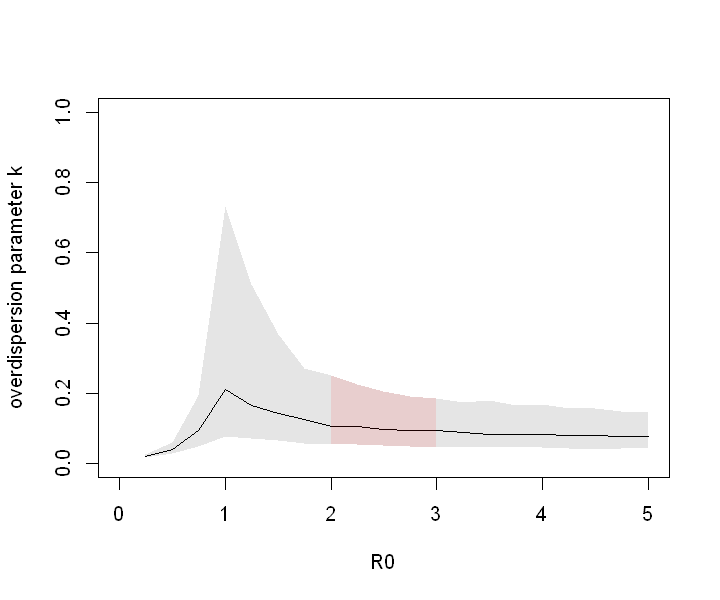

In [7]:
# Plot
med=apply(k_mcmc,2,median)
cri=apply(k_mcmc,2,function(x){quantile(x,c(0.025,0.975))})
plot(x=R0s,y=med,xlim=c(0,5),ylim=c(0,1),type="l",xlab="R0",ylab="overdispersion parameter k")
polygon(x=c(R0s,rev(R0s)),y=c(cri[1,],rev(cri[2,])),lty=0,col=rgb(0,0,0,0.1))
polygon(x=c(seq(2,3,length.out=5),seq(3,2,length.out=5)),y=c(cri[1,8:12],cri[2,12:8]),lty=0,col=rgb(1,0,0,0.1))

### Proportion responsible for 80% of transmissions
Following [Grantz et al.](https://hopkinsidd.github.io/nCoV-Sandbox/DispersionExploration.html), we calculated the estimated proportion of infected individuals responsible for 80% of secondary transmissions caused. Such proportion $p_{80\%}$ is given as
$$
1-p_{80\%}=\int_0^{X}\mathrm{NB}\left(\lfloor x\rfloor;k,\frac{k}{R_0+k}\right)dx,
$$
where $X$ satisfies
$$
1-0.8=\frac 1{R_0}\int_0^{X}\lfloor x\rfloor\mathrm{NB}\left(\lfloor x\rfloor;k,\frac{k}{R_0+k}\right)dx.
$$

Note that
$$
\frac 1{R_0}\int_0^{X}\lfloor x\rfloor\mathrm{NB}\left(\lfloor x\rfloor;k,\frac{k}{R_0+k}\right)dx=\int_0^{X-1}\mathrm{NB}\left(\lfloor x\rfloor;k+1,\frac{k}{R_0+k}\right)dx.
$$

We computed $p_{80\%}$ for each MCMC sample to yield median and 95% CrIs.

In [8]:
# Calculate proportion responsible for 80% of total transmissions
propresponsible=function(R0,k,prop){
    qm1=qnbinom(1-prop,k+1,mu=R0*(k+1)/k)
    remq=1-prop-pnbinom(qm1-1,k+1,mu=R0*(k+1)/k)
    remx=remq/dnbinom(qm1,k+1,mu=R0*(k+1)/k)
    q=qm1+1
    1-pnbinom(q-1,k,mu=R0)+dnbinom(q,k,mu=R0)*remx
}

# test
R0=runif(100,0,5);k=runif(100,0,5)
testprops=sapply(1:length(R0),function(x)propresponsible(R0[x],k[x],1))
all.equal(testprops,1-dnbinom(0,k,mu=R0)) # those generating at least one offspring are responsible for 100% of transmissions

[1] TRUE

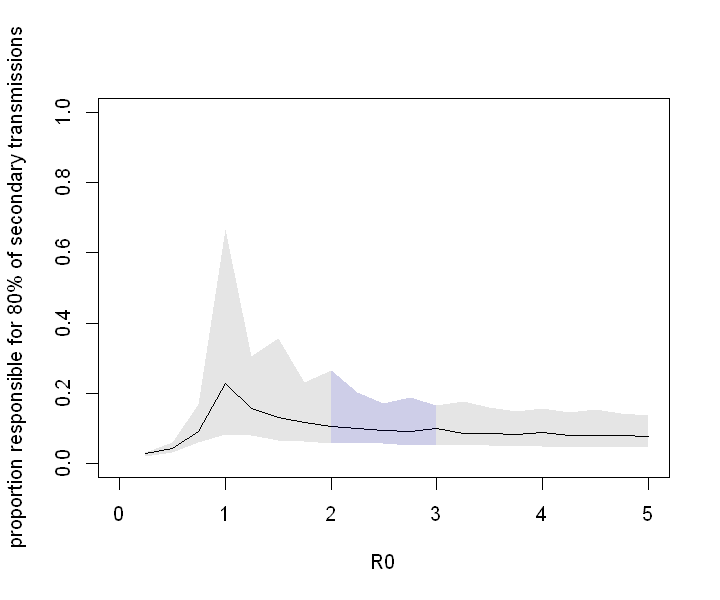

In [9]:
props=sapply(1:length(R0s),function(R0id)sapply(k_mcmc[,R0id],function(k_)propresponsible(R0s[R0id],k_,0.8)))
med=apply(props,2,median)
cri=apply(props,2,function(x){quantile(x,c(0.025,0.975))})
plot(x=R0s,y=med,xlim=c(0,5),ylim=c(0,1),type="l",xlab="R0",ylab="proportion responsible for 80% of secondary transmissions")
polygon(x=c(R0s,rev(R0s)),y=c(cri[1,],rev(cri[2,])),lty=0,col=rgb(0,0,0,0.1))
polygon(x=c(seq(2,3,length.out=5),seq(3,2,length.out=5)),y=c(cri[1,8:12],cri[2,12:8]),lty=0,col=rgb(0,0,1,0.1))

### Joint estimation of $R_{0}$ and $k$
We performed a joint estimation of $R_0$ and $k$ by MCMC (with a weakly-informed normal prior $\mathcal N(\mu=3,\sigma=5)$ for $R_0$; the prior for $k^{-1}$ was the same as above). The posterior distribution indicated that the lower bound of $R_0$ may be 1.4 and the upper bound of $k$ may be 0.2. The upper bound of $R_0$ did not differ from that of the prior, suggesting that our model and data did not contain much information on the upper bound of $R_0$.

In [ ]:
# Joint estimation
Data_joint=list(N=13,mon.names=c("R0","k"),parm.names=c("R0","invk"),icases=icases,lcases=lcases,ocases=ocases,isextinct=isextinct)
Model_joint=function(parm,Data){
    parm=interval(parm,0)
    lp=lltotal(parm,Data$icases,Data$lcases,Data$isextinct)
    lp=lp+dnorm(parm[1],3,5,log=T)+dnorm(parm[2],0,10,log=T)
    return(list(LP=lp,Dev=-2*lp,Monitor=c(parm[1],1/parm[2]),yhat=NULL,parm=parm))
}
niter=10000
fit=LaplacesDemon(Model=Model_joint,Data=Data_joint,Initial.Values=c(1,1),Covar=NULL,Iterations=niter,Status=niter%/%10,Thinning=10,Algorithm='HARM',Specs=list(alpha.star=0.23,B=NULL))

,Mean,SD,MCSE,ESS,LB,Median,UB
R0,5.06506333,2.84184463,0.127371174,649.5488,1.40334350,4.40329657,11.5525352
k,0.09382923,0.04597227,0.002015266,631.5743,0.04355945,0.08145725,0.2088263


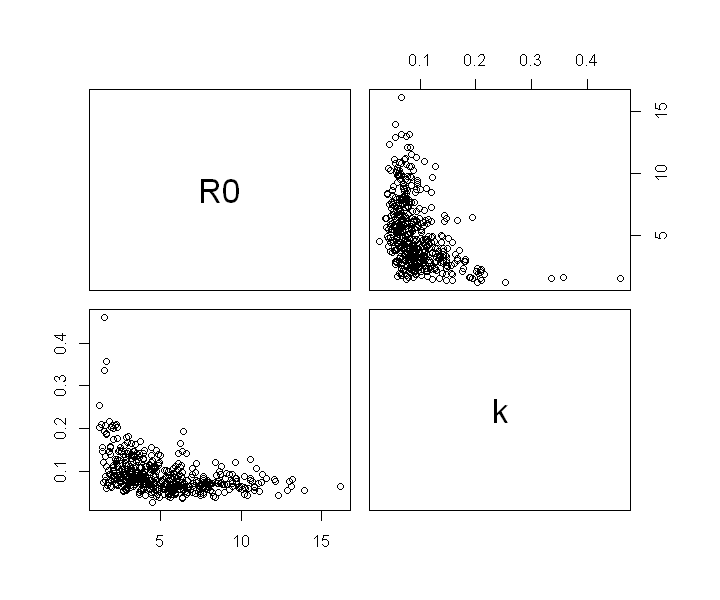

In [11]:
pairs(fit$Monitor[niter%/%20+1:(niter%/%20),1:2])
fit$Summary2[c("R0","k"),]

## Conclusion
We estimated overdispersion of the offspring distribution of COVID-19 from the number of imported/local cases in affected countries. The results suggested that the offspring distribution of COVID-19 is highly overdispersed. For the likely range of $R_0>2$, the overdispersion parameter $k$ was estimated to be around 0.1, suggesting that the majority of secondary transmission is caused by a very small fraction of individuals (80% of transmissions caused by ~10% of the total cases) ([Liu et al.](https://doi.org/10.1016/S0140-6736(20)30462-1)). This suggests that the effective reproduction number could be drastically reduced by interventions targeting potential superspreading events. From the current dataset and model, we were unable to simultaneously estimate $R_0$ and $k$. More detailed dataset on the epidemiological link between cases could improve these estimates in the future.